In [1]:
import getpass
import tempfile
import warnings
from pathlib import Path

from scipy.stats import chisquare
import numpy as np

import astropy.constants as c
import astropy.units as u

from gofish import imagecube
from radmc3dPy import image
import dsharp_opac as opacity
from disklab.radmc3d import write
import disklab

from helper_functions import get_profile_from_fits
from helper_functions import get_normalized_profiles
from helper_functions import make_disklab2d_model
from helper_functions import write_radmc3d
from helper_functions import read_opacs

import pickle
import matplotlib.pyplot as plt
from radmc3dPy import *

/Users/franceschi/mysims/DISKLAB/disklab/diskradial.py:18: UserWarning: numba not available, opacity calculation will be very slow
  warnings.warn('numba not available, opacity calculation will be very slow')


In [2]:
au = c.au.cgs.value
M_sun = c.M_sun.cgs.value
L_sun = c.L_sun.cgs.value
R_sun = c.R_sun.cgs.value

radmc3d_exec = Path('~/bin/radmc3d').expanduser()

In [3]:
options = pickle.load(open("options.p", "rb"))

PA = options['PA']
inc = options['inc']
dpc = options['distance']
clip = options['clip']
lam_mm = options['lam_mm']

mstar = options['mstar']
lstar = options['lstar']
tstar = options['tstar']

# get the mm observables

x_mm_obs = options['x_mm_obs']
y_mm_obs = options['y_mm_obs']
dy_mm_obs = options['dy_mm_obs']
fname_mm_obs = options['fname_mm_obs']

# get options used in the scattered light image

z0 = options['z0']
psi = options['psi']
lam_sca = options['lam_sca']
beam_sca = options['beam_sca']

fname_sca_obs = options['fname_sca_obs']

# get the scattered light data

profiles_sca_obs = options['profiles_sca_obs']

# name of the opacities file

fname_opac = options['fname_opac']

# get the disklab model parameters

nr = options['nr']
rin = options['rin']
r_c = options['r_c']
rout = options['rout']
alpha = options['alpha']

In [4]:
parameters =[
            7.0,
            0.730,
            0.558,
            0.017,
            0.625,
            0.008,
            0.050,
            ]

In [5]:
temp_directory = tempfile.TemporaryDirectory(dir='.')
temp_path = temp_directory.name

# ### make the disklab 2D model

disk2d = make_disklab2d_model(
    parameters,
    mstar,
    lstar,
    tstar,
    nr,
    alpha,
    rin,
    rout,
    r_c,
    fname_opac,
    show_plots=False
)

/Users/franceschi/mysims/IMLup/Til/helper_functions.py:67: UserWarning: Disk mass is unreasonably high: M_disk / Mstar = 0.3
  warnings.warn(f'Disk mass is unreasonably high: M_disk / Mstar = {d.mass/mstar:.2g}')


In [6]:
print(f'disk to star mass ratio = {disk2d.disk.mass / disk2d.disk.mstar:.2g}')

# read the wavelength grid from the opacity file and write out radmc setup

opac_dict = read_opacs(fname_opac)
lam_opac = opac_dict['lam']
n_a = len(opac_dict['a'])

write_radmc3d(disk2d, lam_opac, temp_path, show_plots=False)

disk to star mass ratio = 0.3


In [7]:
# ## Calculate the mm continuum image

fname_mm_sim = Path(temp_path) / 'image_mm.fits'
disklab.radmc3d.radmc3d(
    f'image incl {inc} posang {PA-90} npix 500 lambda {lam_mm * 1e4} sizeau {2 * rout / au} secondorder  setthreads 1',
    path=temp_path,
    executable=str(radmc3d_exec)
)

>>>   
>>>    ================================================================
>>>         WELCOME TO RADMC-3D: A 3-D CONTINUUM AND LINE RT SOLVER
>>>   
>>>                             VERSION 2.0
>>>   
>>>                   (c) 2008-2020 Cornelis Dullemond
>>>   
>>>          Please feel free to ask questions. Also please report
>>>           bugs and/or suspicious behavior without hestitation.
>>>         The reliability of this code depends on your vigilance!
>>>                       dullemond@uni-heidelberg.de
>>>   
>>>      To keep up-to-date with bug-alarms and bugfixes, register to
>>>                        the RADMC-3D forum:
>>>               http://radmc3d.ita.uni-heidelberg.de/phpbb/
>>>   
>>>                 Please visit the RADMC-3D home page at
>>>     http://www.ita.uni-heidelberg.de/~dullemond/software/radmc-3d/
>>>    ================================================================
>>>   
>>>    Number of processors:            8
>>>    Number of threads in use: 

In [8]:
radmc_image = Path(temp_path) / 'image.out'

if radmc_image.is_file():
    im_mm_sim = image.readImage(str(radmc_image))
    radmc_image.replace(Path(temp_path) / 'image_mm.out')
    radmc_image = Path(temp_path) / 'image_mm.out'
    im_mm_sim.writeFits(str(fname_mm_sim), dpc=dpc, coord='15h56m09.17658s -37d56m06.1193s')

Reading tmp5a6xoys8/image.out


Making sure the image looks all right

Reading tmp5a6xoys8/image_mm.out


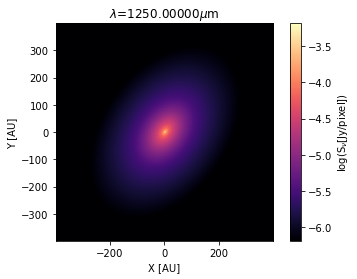

In [9]:
im = image.readImage(str(radmc_image))
plt.figure()
image.plotImage(im ,au=True, log=True, maxlog=3, bunit='jy/pixel', dpc=dpc, cmap='magma');

Creating the imagecube files

In [10]:
iq_mm_obs = imagecube(str(fname_mm_obs), FOV=clip)
iq_mm_sim = imagecube(str(fname_mm_sim))

iq_mm_sim.bmaj, iq_mm_sim.bmin, iq_mm_sim.bpa = iq_mm_obs.beam
iq_mm_sim.beamarea_arcsec = iq_mm_sim._calculate_beam_area_arcsec()
iq_mm_sim.beamarea_str = iq_mm_sim._calculate_beam_area_str()

Checking the output

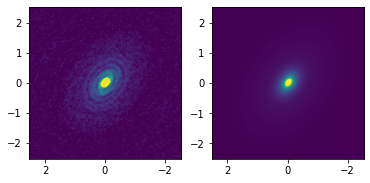

In [11]:
f, ax = plt.subplots(1, 2)

ax[0].imshow(iq_mm_obs.data, extent=iq_mm_obs.extent, vmin=0,vmax=7e-4, origin='lower')

ax[1].imshow(iq_mm_sim.data, extent=iq_mm_sim.extent, vmin=0,vmax=7e-5, origin='lower')

Simulation radial profile using GoFish

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


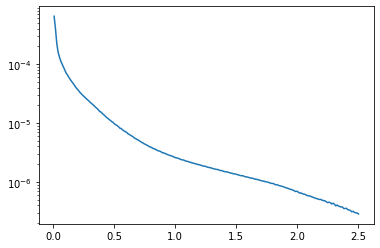

In [12]:
x, y, dy = iq_mm_sim.radial_profile(inc=inc, PA=PA, z0=z0, psi=psi)

f, ax = plt.subplots()
ax.semilogy(x, y);

For some reason, if we include the FOV the data array is empty

UPDATE: for some reason now it works

In [13]:
data = imagecube(str(fname_mm_sim))
print(data.data)

data = imagecube(str(fname_mm_sim), FOV=clip)
print(data.data)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


For this reason, with the clip keyword the following cell does not work.

Default value: 2.5

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


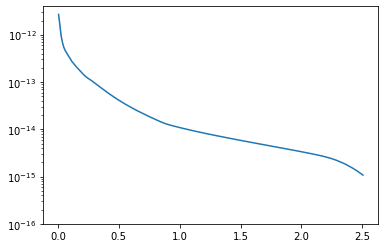

In [14]:
x_mm_sim, y_mm_sim, dy_mm_sim = get_profile_from_fits(
        str(fname_mm_sim),
        clip=clip,
        inc=inc,
        PA=PA,
        z0=0.0,
        psi=0.0,
        beam=iq_mm_obs.beam,
        show_plots=True)

In [15]:
# Maybe here is min, not max?
i_max = min(len(x_mm_obs), len(x_mm_sim))

x_mm_sim = x_mm_sim[:i_max]
y_mm_sim = y_mm_sim[:i_max]
dy_mm_sim = dy_mm_sim[:i_max]
x_mm_obs = x_mm_obs[:i_max]
y_mm_obs = y_mm_obs[:i_max]
dy_mm_obs = dy_mm_obs[:i_max]

In [16]:
if not np.allclose(x_mm_sim, x_mm_obs):
    try:
        from IPython import embed
        embed()
    except Exception:
        raise AssertionError('observed and simulated radial profile grids are not equal')

In [17]:
for i_grain in range(n_a):
    opacity.write_radmc3d_scatmat_file(i_grain, opac_dict, f'{i_grain}', path=temp_path)

with open(Path(temp_path) / 'dustopac.inp', 'w') as f:
    write(f, '2               Format number of this file')
    write(f, '{}              Nr of dust species'.format(n_a))

    for i_grain in range(n_a):
        write(f, '============================================================================')
        write(f, '10               Way in which this dust species is read')
        write(f, '0               0=Thermal grain')
        write(f, '{}              Extension of name of dustscatmat_***.inp file'.format(i_grain))

    write(f, '----------------------------------------------------------------------------')

In [18]:
# image calculation

iq_sca_obs = imagecube(str(fname_sca_obs), FOV=clip)

In [19]:
disklab.radmc3d.radmc3d(
    f'image incl {inc} posang {PA-90} npix {iq_sca_obs.data.shape[0]} lambda {lam_sca / 1e-4} sizeau {2 * rout / au} setthreads 4',
    path=temp_path,
    executable=str(radmc3d_exec))

>>>   
>>>    ================================================================
>>>         WELCOME TO RADMC-3D: A 3-D CONTINUUM AND LINE RT SOLVER
>>>   
>>>                             VERSION 2.0
>>>   
>>>                   (c) 2008-2020 Cornelis Dullemond
>>>   
>>>          Please feel free to ask questions. Also please report
>>>           bugs and/or suspicious behavior without hestitation.
>>>         The reliability of this code depends on your vigilance!
>>>                       dullemond@uni-heidelberg.de
>>>   
>>>      To keep up-to-date with bug-alarms and bugfixes, register to
>>>                        the RADMC-3D forum:
>>>               http://radmc3d.ita.uni-heidelberg.de/phpbb/
>>>   
>>>                 Please visit the RADMC-3D home page at
>>>     http://www.ita.uni-heidelberg.de/~dullemond/software/radmc-3d/
>>>    ================================================================
>>>   
>>>    Number of processors:            8
>>>    Number of threads in use: 

In [20]:
fname_sca_sim = Path(temp_path) / 'image_sca.fits'
if (Path(temp_path) / 'image.out').is_file():
    (Path(temp_path) / 'image.out').replace(fname_sca_sim.with_suffix('.out'))

In [21]:
im = image.readImage(str(fname_sca_sim.with_suffix('.out')))
im.writeFits(str(fname_sca_sim), dpc=dpc, coord='15h56m09.17658s -37d56m06.1193s')

Reading tmp5a6xoys8/image_sca.out


In [22]:
iq_sca_sim = imagecube(str(fname_sca_sim), clip=clip)

# set the "beam" for the two images such that the samplint happens identically

for iq in [iq_sca_obs, iq_sca_sim]:
    iq.bmaj, iq.bmin, iq.bpa = beam_sca
    iq.beamarea_arcsec = iq._calculate_beam_area_arcsec()
    iq.beamarea_str = iq._calculate_beam_area_str()

In [23]:
profiles_sca_sim = get_normalized_profiles(
        str(fname_sca_sim),
        clip=clip,
        inc=inc, PA=PA,
        z0=z0,
        psi=psi,
        beam=beam_sca)

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


/anaconda3/envs/dipsy/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/envs/dipsy/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)


Checking the profiles

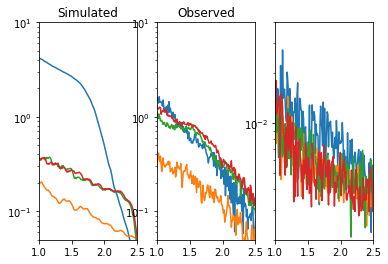

In [24]:
f, ax = plt.subplots(1, 3)

for i, key in enumerate(profiles_sca_sim.keys()):
    profile = profiles_sca_sim[key]
    x = profile['x']
    y = profile['y']
    dy = profile['dy']
    mask = profile['mask']

    ax[0].semilogy(x, y, c=f'C{i}')
    ax[0].fill_between(x, y - dy, y + dy, fc=f'C{i}', alpha=0.5)

for i, key in enumerate(profiles_sca_obs.keys()):
    profile = profiles_sca_obs[key]
    x = profile['x']
    y = profile['y']
    dy = profile['dy']
    mask = profile['mask']

    ax[1].semilogy(x, y, c=f'C{i}')
    ax[1].fill_between(x, y - dy, y + dy, fc=f'C{i}', alpha=0.5)
    ax[2].semilogy(x, dy, c=f'C{i}')

ax[0].set_xlim([1,2.5])
ax[0].set_ylim([5e-2, 1e1])
ax[0].set_title('Simulated')
ax[1].set_xlim([1,2.5])
ax[1].set_ylim([5e-2, 1e1])
ax[1].set_title('Observed')
ax[2].set_xlim([1,2.5])
ax[2].set_ylim([2e-3, 4e-2]);

In [25]:
try:
    assert np.allclose(profiles_sca_obs['B']['x'], profiles_sca_sim['B']['x'])
except Exception:
    # raise AssertionError('observed and simulated radial profile grids are not equal')
    warnings.warn('observed and simulated radial profile grids are not equal')
    # try:
    #     from IPython import embed
    #     embed()
    # except Exception:
    #     pass

/anaconda3/envs/dipsy/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: observed and simulated radial profile grids are not equal
  """


In [26]:
def calculate_chisq(obs, exp, error):
    error = error + 1e-100
    return np.sum((obs - exp) ** 2 / (error ** 2))

In [27]:
y_sim_full = np.array([])
y_obs_full = np.array([])
dy_obs_full = np.array([])

for i, key in enumerate(profiles_sca_obs.keys()):
    profile = profiles_sca_obs[key]
    x_obs = profile['x']
    y_obs = profile['y']
    dy_obs = profile['dy']
    mask_obs = profile['mask']
    index_outer_disk = np.asarray(x_obs >= 1).nonzero()[0][0]


    profile = profiles_sca_sim[key]
    x_sim = profile['x']
    y_sim = profile['y']
    dy_sim = profile['dy']
    mask_sim = profile['mask']

    index_disk_size = min(len(x_obs), len(x_sim))

    y_sim_full = np.append(y_sim_full, y_sim[index_outer_disk:index_disk_size])
    y_obs_full = np.append(y_obs_full, y_obs[index_outer_disk:index_disk_size])
    dy_obs_full = np.append(dy_obs_full, dy_obs[index_outer_disk:index_disk_size])

In [28]:
chisq = calculate_chisq(y_obs_full, y_sim_full, dy_obs_full)

logP = -np.log(chisq)

print(chisq, logP)

# !jupyter nbconvert --to python logP_testing.ipynb


5904576.628600797 -15.591238307939225
[NbConvertApp] Converting notebook logP_testing.ipynb to python
[NbConvertApp] Writing 9471 bytes to logP_testing.py
